In [1]:
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt


# import pandas as pd
# import os
# from PIL import Image
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
train_metadata_path = "/kaggle/input/bdma-compatition/BDMA7_project_files/train_metadata.csv"  # Path to the metadata file
train_images_dir = "/kaggle/input/bdma-compatition/BDMA7_project_files/train_images"           # Path to training images directory
val_metadata_path = "/kaggle/input/bdma-compatition/BDMA7_project_files/val_metadata.csv"      # Path to validation metadata file
val_images_dir = "/kaggle/input/bdma-compatition/BDMA7_project_files/val_images"               # Path to validation images directory

In [4]:
class BirdDataset(Dataset):
    def __init__(self, metadata, images_dir, transform=None):
        self.metadata = metadata
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.metadata.iloc[idx]["path"])
        label = self.metadata.iloc[idx]["class_idx"]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
train_metadata = pd.read_csv(train_metadata_path)
val_metadata = pd.read_csv(val_metadata_path)

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
])

In [7]:
train_dataset = BirdDataset(train_metadata, train_images_dir, transform=transform)
val_dataset = BirdDataset(val_metadata, val_images_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [8]:
num_classes = train_metadata["class_idx"].nunique()
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.3MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

In [11]:
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_losses.append(val_loss / len(val_loader))
    accuracy = correct / total * 100

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {accuracy:.2f}%")

Epoch 10/10, Train Loss: 0.2466, Val Loss: 0.9410, Val Accuracy: 65.05%


In [12]:
torch.save(model.state_dict(), "bird_classification_model.pth")

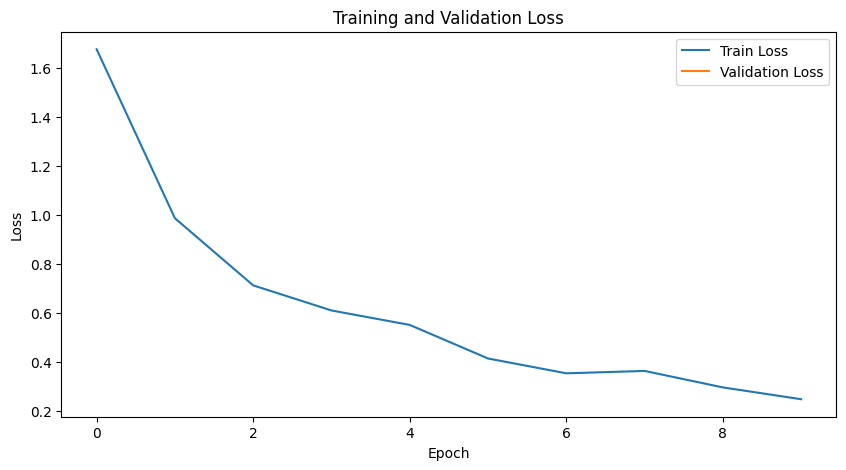

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [14]:
# Custom Test Dataset Class
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_paths = sorted(os.listdir(test_dir))  # Sort to ensure consistent order
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.test_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

# Define the test data directory and transformations
test_dir = "/kaggle/input/bdma-compatition/BDMA7_project_files/test_images/mistery_cat"  # Replace with the actual path to your test images
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model.load_state_dict(torch.load("/kaggle/working/bird_classification_model.pth"))
model.eval()  # Set the model to evaluation mode

# Generate predictions
predictions = []
image_names = []

with torch.no_grad():
    for inputs, image_paths in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # Get the predicted class index
        predictions.extend(predicted.cpu().numpy())
        image_names.extend(image_paths)

# Save predictions to CSV
submission_df = pd.DataFrame({
    "path": image_names,
    "class_idx": predictions
})
submission_df.to_csv("submission.csv", index=False)
print("Predictions saved to submission.csv!")

<ipython-input-14-85937494f40b>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/bird_classification_model.pth"))


Predictions saved to submission.csv!


some modifications to solve the model crash

In [15]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_paths = [
            fname for fname in sorted(os.listdir(test_dir))
            if os.path.isfile(os.path.join(test_dir, fname))
        ]  # Only include files
        self.transform = transform

        # Debugging: Print the number of valid image files
        print(f"Found {len(self.image_paths)} valid image files in the test directory.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.test_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_paths[idx]

In [16]:
test_dir = "/kaggle/input/bdma-compatition/BDMA7_project_files/test_images"  # Replace with your actual test images path
if not os.path.exists(test_dir):
    print(f"Error: The directory {test_dir} does not exist.")
else:
    print(f"The directory {test_dir} exists.")

The directory /kaggle/input/bdma-compatition/BDMA7_project_files/test_images exists.


In [17]:
print("Contents of the test directory:", os.listdir(test_dir))

Contents of the test directory: ['mistery_cat']
